In [82]:
import pandas as pd
import numpy as np
import os
import time
from astropy.cosmology import Planck13
from astropy.io import fits
from astropy.table import Table
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt

import disperse

from sklearn.neighbors import KDTree
from sklearn.decomposition import PCA

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgbm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
cosmo = Planck13
H0 = cosmo.H0.value
Om = cosmo.Om0
Ol = 0.69288
Ok = 0.0
print(f'H0 = {cosmo.H0.value}')
print(f'Om = {cosmo.Om0}')
print(f'Ol = {0.69288}')

H0 = 67.77
Om = 0.30712
Ol = 0.69288


In [3]:
np.random.seed(0)

In [4]:
gal_RA_int = (140, 260)
gal_DEC_int = (-10, 30)
gal_Z_int = (0, 1.0)

In [5]:
# galaxies = pd.read_csv('SDSS/SDSS_DR16.csv')
# galaxies = galaxies[galaxies['class'] == 'GALAXY']
# galaxies = galaxies[(gal_RA_int[0] <= galaxies['ra']) & (galaxies['ra'] <= gal_RA_int[1])]
# galaxies = galaxies[(gal_DEC_int[0] <= galaxies['dec']) & (galaxies['dec'] <= gal_DEC_int[1])]
# galaxies = galaxies[(gal_Z_int[0] < galaxies['z']) & (galaxies['z'] <= gal_Z_int[1])]
# galaxies = galaxies[['ra', 'dec', 'z']]
# galaxies.columns = ['RA', 'DEC', 'Z']
# galaxies = galaxies.sort_values(by=['Z'])
# galaxies.drop_duplicates(subset=['RA', 'DEC', 'Z'])
# galaxies.reset_index(drop=True, inplace=True)

In [6]:
# util_DPS = disperse.Disperse3D(
#     galaxies, '_disperse_03/bin/',
#     H0, Om, Ol, Ok,
#     clusters=None
# )

In [7]:
# CX, CY, CZ = util_DPS.sph2cart(galaxies['RA'], galaxies['DEC'], galaxies['Z'])
# galaxies['CX'] = CX
# galaxies['CY'] = CY
# galaxies['CZ'] = CZ
# galaxies['ID'] = list(range(galaxies.shape[0]))

In [8]:
# galaxies.to_csv('ACT_06_galaxies.csv', index=False)
galaxies = pd.read_csv('ACT_06_galaxies.csv')
galaxies

,RA,DEC,Z,CX,CY,CZ,ID
0,246.57670,24.555640,4.440446e-07,-0.000710,-0.001639,0.000816,0
1,164.13474,26.790246,2.660330e-06,-0.010105,0.002872,0.005304,1
2,148.27174,13.852512,2.941728e-06,-0.010746,0.006644,0.003116,2
3,162.39490,0.634081,2.985324e-06,-0.012587,0.003994,0.000146,3
4,192.18382,29.157491,4.336780e-06,-0.016376,-0.003536,0.009347,4
...,...,...,...,...,...,...,...
931855,150.82080,27.459191,9.999520e-01,-2632.647935,1470.083208,1566.932516,931855
931856,145.90217,17.815348,9.999526e-01,-2678.991489,1813.665628,1039.658140,931856
931857,148.54341,23.989890,9.999846e-01,-2648.386298,1620.174441,1381.627428,931857
931858,172.28138,22.292154,9.999892e-01,-3115.753059,422.297455,1289.044302,931858


Text(0.5, 1.0, 'Z > 0.7')

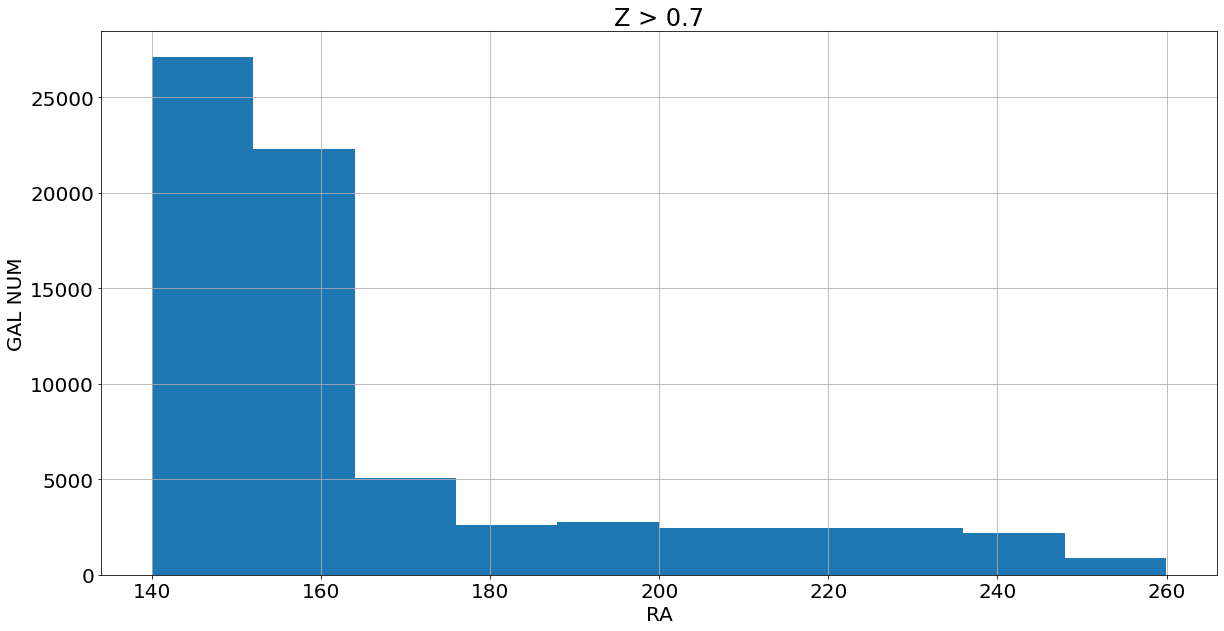

In [9]:
t_ = galaxies[(galaxies['Z'] > 0.7)]['RA'].values

font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(20, 10))
plt.grid()

plt.hist(t_)

plt.xlabel('RA')
plt.ylabel('GAL NUM')
plt.title('Z > 0.7')

In [10]:
util_DPS = disperse.Disperse3D(
    galaxies, '_disperse_03/bin/',
    H0, Om, Ol, Ok,
    clusters=None
)

In [11]:
cl_RA_int = (160, 240)
cl_DEC_int = (0, 20)
cl_Z_int = (0, 1.0)

In [12]:
# dat = Table.read('DR5_cluster-catalog_v1.1.fits', format='fits')
# true_clusters = dat[['RADeg', 'decDeg', 'redshift', 'redshiftType', 'M500c']].to_pandas()
# true_clusters = true_clusters[true_clusters['redshiftType'] == b'spec']
# true_clusters = true_clusters[['RADeg', 'decDeg', 'redshift', 'M500c']]
# true_clusters.columns = ['RA', 'DEC', 'Z', 'M']
# true_clusters = true_clusters[(cl_RA_int[0] <= true_clusters['RA']) & (true_clusters['RA'] <= cl_RA_int[1])]
# true_clusters = true_clusters[(cl_DEC_int[0] <= true_clusters['DEC']) & (true_clusters['DEC'] <= cl_DEC_int[1])]
# true_clusters = true_clusters[(cl_Z_int[0] < true_clusters['Z']) & (true_clusters['Z'] <= cl_Z_int[1])]
# true_clusters = true_clusters[['RA', 'DEC', 'Z', 'M']]
# true_clusters.columns = ['RA', 'DEC', 'Z', 'M']
# true_clusters.drop_duplicates(subset=['RA', 'DEC', 'Z', 'M'])
# true_clusters = true_clusters.sort_values(by=['Z'])
# true_clusters.reset_index(drop=True, inplace=True)
# true_clusters['R'] = [0] * true_clusters.shape[0]
# true_clusters['type'] = [1] * true_clusters.shape[0]
# CX, CY, CZ = util_DPS.sph2cart(true_clusters['RA'], true_clusters['DEC'], true_clusters['Z'])
# true_clusters['CX'] = CX
# true_clusters['CY'] = CY
# true_clusters['CZ'] = CZ
# true_clusters['ID'] = list(range(true_clusters.shape[0]))
# true_clusters

In [13]:
# RANDOM_CL_RATIO = 8

# RA, DEC, Z, CX, CY, CZ = [], [], [], [], [], []

# used_gals = set([None])

# for i in tqdm(range(true_clusters.shape[0])):
#     z = true_clusters.iloc[i]['Z']
#     cands = galaxies[(galaxies['Z'] >= (z - 0.01)) & (galaxies['Z'] <= (z + 0.01))]
#     ids = [None]
#     while len(used_gals.intersection(ids)) > 0:
#         cands_01 = cands.iloc[np.random.choice(list(range(cands.shape[0])), RANDOM_CL_RATIO, replace=False)]
#         ids = list(cands_01['ID'])
#     used_gals = used_gals.union(ids)
#     for j in range(cands_01.shape[0]):
#         row = cands_01.iloc[j]
#         RA.append(row['RA'])
#         DEC.append(row['DEC'])
#         Z.append(row['Z'])
#         CX.append(row['CX'])
#         CY.append(row['CY'])
#         CZ.append(row['CZ'])
        
# false_clusters = pd.DataFrame({
#     'RA': RA, 'DEC': DEC, 'Z': Z,
#     'M': [0] * true_clusters.shape[0] * RANDOM_CL_RATIO,
#     'R': [0] * true_clusters.shape[0] * RANDOM_CL_RATIO,
#     'type': [0] * true_clusters.shape[0] * RANDOM_CL_RATIO,
#     'CX': CX, 'CY': CY, 'CZ': CZ,
# })
# false_clusters = false_clusters.sort_values(by=['Z'])
# false_clusters.reset_index(drop=True, inplace=True)
# false_clusters['ID'] = list(range(true_clusters.shape[0], true_clusters.shape[0] * (RANDOM_CL_RATIO + 1)))    
# false_clusters

In [14]:
# clusters = pd.concat((true_clusters, false_clusters), axis=0)
# clusters.reset_index(drop=True, inplace=True)
# clusters

In [15]:
sigmas = [round(i, 1) for i in np.arange(0.2, 14.2, 0.2)]

In [16]:
# f_name = 'ACT_06_dists.npy'
# if os.path.exists(f_name):
#     with open(f_name, 'rb') as f:
#         dists = np.load(f)
# else:
#     dists = []
#     for sigma in tqdm(sigmas):
#         DPS = disperse.Disperse3D.read(f'ACT_01_dumps/{sigma}/')

#         _, _, cl_dists \
#             = DPS.count_conn(clusters['R'], clusters)
#         dists.append(np.array(cl_dists)[None,:])
#     dists = np.concatenate(dists, axis=0)
#     dists = dists.T
#     with open(f_name, 'wb') as f:
#         np.save(f, dists)
    
# print(dists.shape)

In [17]:
# for i, sigma in enumerate(sigmas):
#     true_clusters[f'dist_{sigma}'] = dists[:true_clusters.shape[0], i]
#     false_clusters[f'dist_{sigma}'] = dists[true_clusters.shape[0]:, i]
#     clusters[f'dist_{sigma}'] = dists[:, i]

In [18]:
# true_clusters.to_csv('ACT_06_true_clusters.csv', index=False)
# false_clusters.to_csv('ACT_06_false_clusters.csv', index=False)
# clusters.to_csv('ACT_06_clusters.csv', index=False)

true_clusters = pd.read_csv('ACT_06_true_clusters.csv')
false_clusters = pd.read_csv('ACT_06_false_clusters.csv')
clusters = pd.read_csv('ACT_06_clusters.csv')

In [19]:
true_clusters

,RA,DEC,Z,M,R,type,CX,CY,CZ,ID,...,dist_12.2,dist_12.4,dist_12.6,dist_12.8,dist_13.0,dist_13.2,dist_13.4,dist_13.6,dist_13.8,dist_14.0
0,230.761495,8.587807,0.035200,1.676978,0,1,-96.597031,-118.277283,23.062053,0,...,6.432487,101.423067,101.423067,101.423067,101.423067,101.423067,101.423067,101.423067,101.423067,101.423067
1,230.452957,7.709549,0.044200,2.457475,0,1,-122.101803,-147.873793,25.960786,1,...,8.378063,135.818132,135.818132,135.818132,135.818132,135.818132,135.818132,135.818132,135.818132,135.818132
2,227.733561,5.744353,0.076600,11.002140,0,1,-222.703294,-245.035914,33.308899,2,...,1.570683,267.106804,267.106804,267.106804,267.106804,267.106804,267.106804,267.106804,267.106804,267.106804
3,208.253128,5.139146,0.078800,1.222567,0,1,-300.190348,-161.319215,30.649445,3,...,1.138946,223.929466,223.929466,223.929466,223.929466,223.929466,223.929466,223.929466,223.929466,223.929466
4,173.207731,14.465334,0.083200,2.935207,0,1,-346.994931,41.329156,90.147741,4,...,19.328642,127.612739,127.612739,127.612739,127.612739,127.612739,127.612739,127.612739,127.612739,127.612739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514,190.801637,13.213381,0.789772,1.827705,0,1,-2716.094276,-518.203135,649.226460,514,...,860.519682,860.519682,860.519682,860.519682,860.519682,860.519682,860.519682,860.519682,860.519682,860.519682
515,160.265704,10.675110,0.789868,4.328044,0,1,-2627.451148,942.538451,526.183483,515,...,1086.108102,1086.108102,1086.108102,1086.108102,1086.108102,1086.108102,1086.108102,1086.108102,1086.108102,1086.108102
516,199.909131,15.890405,0.796336,1.899555,0,1,-2585.211521,-936.299514,782.729567,516,...,922.943746,922.943746,922.943746,922.943746,922.943746,922.943746,922.943746,922.943746,922.943746,922.943746
517,211.772844,10.806421,0.836000,6.430338,0,1,-2479.343209,-1535.631547,556.669132,517,...,756.876812,756.876812,756.876812,756.876812,756.876812,756.876812,756.876812,756.876812,756.876812,756.876812


In [20]:
false_clusters

,RA,DEC,Z,M,R,type,CX,CY,CZ,ID,...,dist_12.2,dist_12.4,dist_12.6,dist_12.8,dist_13.0,dist_13.2,dist_13.4,dist_13.6,dist_13.8,dist_14.0
0,145.66877,6.538244,0.028617,0,0,0,-103.168740,70.459375,14.318823,519,...,43.006360,43.006360,43.006360,43.006360,43.006360,43.006360,43.006360,43.006360,43.006360,43.006360
1,251.31184,22.138445,0.031120,0,0,0,-40.563595,-119.921574,51.504350,520,...,62.659045,105.575331,105.575331,105.575331,105.575331,105.575331,105.575331,105.575331,105.575331,105.575331
2,173.09283,22.626455,0.031473,0,0,0,-126.648403,15.342222,53.173179,521,...,34.937361,34.937361,34.937361,34.937361,34.937361,34.937361,34.937361,34.937361,34.937361,34.937361
3,236.31230,26.457349,0.032845,0,0,0,-71.601283,-107.411540,64.241489,522,...,50.105040,89.821407,89.821407,89.821407,89.821407,89.821407,89.821407,89.821407,89.821407,89.821407
4,164.25191,29.621996,0.034285,0,0,0,-125.884700,35.498627,74.367851,523,...,48.512655,48.512655,48.512655,48.512655,48.512655,48.512655,48.512655,48.512655,48.512655,48.512655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4147,163.46491,24.503729,0.975067,0,0,0,-2909.697353,863.830335,1383.466601,4666,...,1602.690453,1602.690453,1602.690453,1602.690453,1602.690453,1602.690453,1602.690453,1602.690453,1602.690453,1602.690453
4148,157.78732,23.798123,0.975247,0,0,0,-2825.907553,1153.961125,1346.166268,4667,...,1717.464901,1717.464901,1717.464901,1717.464901,1717.464901,1717.464901,1717.464901,1717.464901,1717.464901,1717.464901
4149,147.77115,29.443591,0.978454,0,0,0,-2463.556399,1553.117205,1643.896978,4668,...,1974.920408,1974.920408,1974.920408,1974.920408,1974.920408,1974.920408,1974.920408,1974.920408,1974.920408,1974.920408
4150,164.53924,25.832270,0.981837,0,0,0,-2908.505066,804.455111,1460.913487,4669,...,1603.318789,1603.318789,1603.318789,1603.318789,1603.318789,1603.318789,1603.318789,1603.318789,1603.318789,1603.318789


In [21]:
clusters

,RA,DEC,Z,M,R,type,CX,CY,CZ,ID,...,dist_12.2,dist_12.4,dist_12.6,dist_12.8,dist_13.0,dist_13.2,dist_13.4,dist_13.6,dist_13.8,dist_14.0
0,230.761495,8.587807,0.035200,1.676978,0,1,-96.597031,-118.277283,23.062053,0,...,6.432487,101.423067,101.423067,101.423067,101.423067,101.423067,101.423067,101.423067,101.423067,101.423067
1,230.452957,7.709549,0.044200,2.457475,0,1,-122.101803,-147.873793,25.960786,1,...,8.378063,135.818132,135.818132,135.818132,135.818132,135.818132,135.818132,135.818132,135.818132,135.818132
2,227.733561,5.744353,0.076600,11.002140,0,1,-222.703294,-245.035914,33.308899,2,...,1.570683,267.106804,267.106804,267.106804,267.106804,267.106804,267.106804,267.106804,267.106804,267.106804
3,208.253128,5.139146,0.078800,1.222567,0,1,-300.190348,-161.319215,30.649445,3,...,1.138946,223.929466,223.929466,223.929466,223.929466,223.929466,223.929466,223.929466,223.929466,223.929466
4,173.207731,14.465334,0.083200,2.935207,0,1,-346.994931,41.329156,90.147741,4,...,19.328642,127.612739,127.612739,127.612739,127.612739,127.612739,127.612739,127.612739,127.612739,127.612739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4666,163.464910,24.503729,0.975067,0.000000,0,0,-2909.697353,863.830335,1383.466601,4666,...,1602.690453,1602.690453,1602.690453,1602.690453,1602.690453,1602.690453,1602.690453,1602.690453,1602.690453,1602.690453
4667,157.787320,23.798123,0.975247,0.000000,0,0,-2825.907553,1153.961125,1346.166268,4667,...,1717.464901,1717.464901,1717.464901,1717.464901,1717.464901,1717.464901,1717.464901,1717.464901,1717.464901,1717.464901
4668,147.771150,29.443591,0.978454,0.000000,0,0,-2463.556399,1553.117205,1643.896978,4668,...,1974.920408,1974.920408,1974.920408,1974.920408,1974.920408,1974.920408,1974.920408,1974.920408,1974.920408,1974.920408
4669,164.539240,25.832270,0.981837,0.000000,0,0,-2908.505066,804.455111,1460.913487,4669,...,1603.318789,1603.318789,1603.318789,1603.318789,1603.318789,1603.318789,1603.318789,1603.318789,1603.318789,1603.318789


In [22]:
Z_MAX = 0.6
Z_MIN = 0.02

In [23]:
m_f = (clusters['Z'] <= Z_MAX) & (clusters['Z'] >= Z_MIN)
clusters_f = clusters[m_f].copy()
clusters_f['ID'] = list(range(clusters_f.shape[0]))
clusters_f.reset_index(drop=True, inplace=True)
clusters_f

,RA,DEC,Z,M,R,type,CX,CY,CZ,ID,...,dist_12.2,dist_12.4,dist_12.6,dist_12.8,dist_13.0,dist_13.2,dist_13.4,dist_13.6,dist_13.8,dist_14.0
0,230.761495,8.587807,0.035200,1.676978,0,1,-96.597031,-118.277283,23.062053,0,...,6.432487,101.423067,101.423067,101.423067,101.423067,101.423067,101.423067,101.423067,101.423067,101.423067
1,230.452957,7.709549,0.044200,2.457475,0,1,-122.101803,-147.873793,25.960786,1,...,8.378063,135.818132,135.818132,135.818132,135.818132,135.818132,135.818132,135.818132,135.818132,135.818132
2,227.733561,5.744353,0.076600,11.002140,0,1,-222.703294,-245.035914,33.308899,2,...,1.570683,267.106804,267.106804,267.106804,267.106804,267.106804,267.106804,267.106804,267.106804,267.106804
3,208.253128,5.139146,0.078800,1.222567,0,1,-300.190348,-161.319215,30.649445,3,...,1.138946,223.929466,223.929466,223.929466,223.929466,223.929466,223.929466,223.929466,223.929466,223.929466
4,173.207731,14.465334,0.083200,2.935207,0,1,-346.994931,41.329156,90.147741,4,...,19.328642,127.612739,127.612739,127.612739,127.612739,127.612739,127.612739,127.612739,127.612739,127.612739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3605,145.694830,20.000573,0.599121,0.000000,0,0,-1761.773562,1202.033401,776.290872,3605,...,1228.535376,1228.535376,1228.535376,1228.535376,1228.535376,1228.535376,1228.535376,1228.535376,1228.535376,1228.535376
3606,206.866290,20.280894,0.599166,0.000000,0,0,-1899.280928,-962.155576,786.766171,3606,...,320.914717,320.914717,320.914717,320.914717,320.914717,320.914717,320.914717,320.914717,320.914717,320.914717
3607,190.753410,-2.402129,0.599358,0.000000,0,0,-2228.581523,-423.246840,-95.159252,3607,...,392.246073,392.246073,392.246073,392.246073,392.246073,392.246073,392.246073,392.246073,392.246073,392.246073
3608,248.989550,10.852088,0.599358,0.000000,0,0,-799.472293,-2081.561694,427.460377,3608,...,651.195865,651.195865,651.195865,651.195865,651.195865,651.195865,651.195865,651.195865,651.195865,651.195865


In [77]:
true_clusters_f = clusters_f[clusters_f['type'] == 1]
true_clusters_f.reset_index(drop=True, inplace=True)
true_clusters_f

,RA,DEC,Z,M,R,type,CX,CY,CZ,ID,...,dist_12.2,dist_12.4,dist_12.6,dist_12.8,dist_13.0,dist_13.2,dist_13.4,dist_13.6,dist_13.8,dist_14.0
0,230.761495,8.587807,0.035200,1.676978,0,1,-96.597031,-118.277283,23.062053,0,...,6.432487,101.423067,101.423067,101.423067,101.423067,101.423067,101.423067,101.423067,101.423067,101.423067
1,230.452957,7.709549,0.044200,2.457475,0,1,-122.101803,-147.873793,25.960786,1,...,8.378063,135.818132,135.818132,135.818132,135.818132,135.818132,135.818132,135.818132,135.818132,135.818132
2,227.733561,5.744353,0.076600,11.002140,0,1,-222.703294,-245.035914,33.308899,2,...,1.570683,267.106804,267.106804,267.106804,267.106804,267.106804,267.106804,267.106804,267.106804,267.106804
3,208.253128,5.139146,0.078800,1.222567,0,1,-300.190348,-161.319215,30.649445,3,...,1.138946,223.929466,223.929466,223.929466,223.929466,223.929466,223.929466,223.929466,223.929466,223.929466
4,173.207731,14.465334,0.083200,2.935207,0,1,-346.994931,41.329156,90.147741,4,...,19.328642,127.612739,127.612739,127.612739,127.612739,127.612739,127.612739,127.612739,127.612739,127.612739
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,197.140236,16.590121,0.595016,1.837801,0,1,-2066.645002,-637.372030,644.322395,396,...,321.409274,321.409274,321.409274,321.409274,321.409274,321.409274,321.409274,321.409274,321.409274,321.409274
397,180.280038,17.277039,0.595392,2.125170,0,1,-2155.933129,-10.537378,670.558738,397,...,337.016150,337.016150,337.016150,337.016150,337.016150,337.016150,337.016150,337.016150,337.016150,337.016150
398,226.178018,4.613074,0.596241,2.969766,0,1,-1560.164568,-1625.675583,181.806102,398,...,74.692903,74.692903,74.692903,74.692903,74.692903,74.692903,74.692903,74.692903,74.692903,74.692903
399,204.487309,8.539487,0.597085,2.168032,0,1,-2036.802407,-927.679544,336.065403,399,...,447.023461,447.023461,447.023461,447.023461,447.023461,447.023461,447.023461,447.023461,447.023461,447.023461


In [78]:
false_clusters_f = clusters_f[clusters_f['type'] == 0]
false_clusters_f.reset_index(drop=True, inplace=True)
false_clusters_f

,RA,DEC,Z,M,R,type,CX,CY,CZ,ID,...,dist_12.2,dist_12.4,dist_12.6,dist_12.8,dist_13.0,dist_13.2,dist_13.4,dist_13.6,dist_13.8,dist_14.0
0,145.66877,6.538244,0.028617,0.0,0,0,-103.168740,70.459375,14.318823,401,...,43.006360,43.006360,43.006360,43.006360,43.006360,43.006360,43.006360,43.006360,43.006360,43.006360
1,251.31184,22.138445,0.031120,0.0,0,0,-40.563595,-119.921574,51.504350,402,...,62.659045,105.575331,105.575331,105.575331,105.575331,105.575331,105.575331,105.575331,105.575331,105.575331
2,173.09283,22.626455,0.031473,0.0,0,0,-126.648403,15.342222,53.173179,403,...,34.937361,34.937361,34.937361,34.937361,34.937361,34.937361,34.937361,34.937361,34.937361,34.937361
3,236.31230,26.457349,0.032845,0.0,0,0,-71.601283,-107.411540,64.241489,404,...,50.105040,89.821407,89.821407,89.821407,89.821407,89.821407,89.821407,89.821407,89.821407,89.821407
4,164.25191,29.621996,0.034285,0.0,0,0,-125.884700,35.498627,74.367851,405,...,48.512655,48.512655,48.512655,48.512655,48.512655,48.512655,48.512655,48.512655,48.512655,48.512655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3204,145.69483,20.000573,0.599121,0.0,0,0,-1761.773562,1202.033401,776.290872,3605,...,1228.535376,1228.535376,1228.535376,1228.535376,1228.535376,1228.535376,1228.535376,1228.535376,1228.535376,1228.535376
3205,206.86629,20.280894,0.599166,0.0,0,0,-1899.280928,-962.155576,786.766171,3606,...,320.914717,320.914717,320.914717,320.914717,320.914717,320.914717,320.914717,320.914717,320.914717,320.914717
3206,190.75341,-2.402129,0.599358,0.0,0,0,-2228.581523,-423.246840,-95.159252,3607,...,392.246073,392.246073,392.246073,392.246073,392.246073,392.246073,392.246073,392.246073,392.246073,392.246073
3207,248.98955,10.852088,0.599358,0.0,0,0,-799.472293,-2081.561694,427.460377,3608,...,651.195865,651.195865,651.195865,651.195865,651.195865,651.195865,651.195865,651.195865,651.195865,651.195865


In [24]:
dists = []
for sigma in sigmas:
    dists.append(clusters[f'dist_{sigma}'].values)
dists = np.array(dists).T
dists.shape

(4671, 70)

In [25]:
dists_f = dists[m_f]

In [26]:
clusters_f[clusters_f['type'] == 0].shape

(3209, 80)

Text(0.5, 1.0, 'Распределение расстояний до ближайшего волокна')

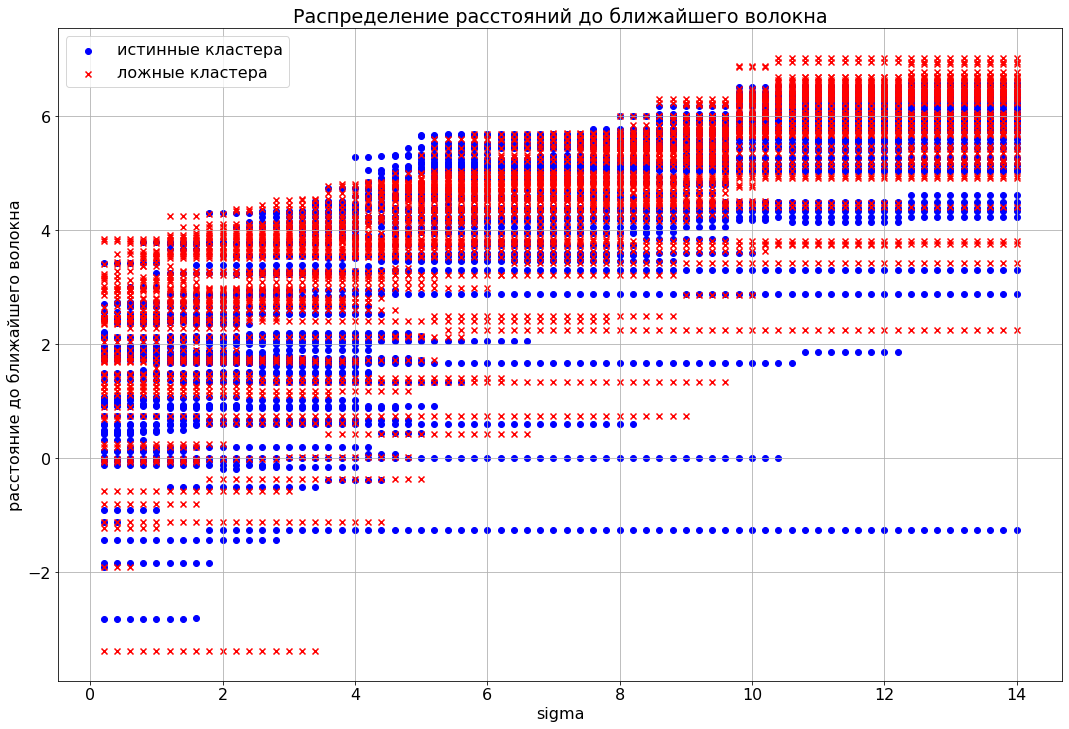

In [27]:
t_dists = dists_f[:401:8]
f_dists = dists_f[401::60]

font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(18, 12))
plt.grid()
# plt.yticks(np.arange(0, 3.6, 0.2))
# plt.ylim((0, 3.4))

for i in range(t_dists.shape[0]):
    if i == 0:
        plt.scatter(sigmas, np.log(t_dists[i]), c='b', marker='o', label='истинные кластера')
    else:
        plt.scatter(sigmas, np.log(t_dists[i]), c='b', marker='o')
    
for i in range(f_dists.shape[0]):
    if i == 0:
        plt.scatter(sigmas, np.log(f_dists[i]), c ='r', marker='x', label='ложные кластера')
    else:
        plt.scatter(sigmas, np.log(f_dists[i]), c ='r', marker='x')
    
plt.xlabel('sigma')
plt.ylabel('расстояние до ближайшего волокна')
plt.legend()
plt.title(f'Распределение расстояний до ближайшего волокна')

In [28]:
FOLDS_NUM = 2

folds = []

for i in range(FOLDS_NUM):
    test_index = list(range(i, clusters_f.shape[0], FOLDS_NUM))
    train_index = set(range(clusters_f.shape[0])) - set(test_index)
    train_index = sorted(train_index)
    folds.append((train_index, test_index))

In [29]:
def gen_feas(galaxies, clusters):
    cl_coords = np.array([
        clusters['CX'].values,
        clusters['CY'].values,
        clusters['CZ'].values
    ]).T
    
    g_coords = np.array([
        galaxies['CX'].values,
        galaxies['CY'].values,
        galaxies['CZ'].values
    ]).T
    kd_tree = KDTree(g_coords)
    
    cme_rads = [0.2, 0.5, 0.8, 1.0, 1.5, 2.0, 3.0, 5.0, 7.5, 10.0, 12.0]
    cmd = []
    mi = []
    enc = []
    
    for r in tqdm(cme_rads):
        nn_idx, nn_dists = kd_tree.query_radius(cl_coords, r=r, return_distance=True)
        t_cmd = []
        t_mi = []
        t_enc = []
        for i, idx in enumerate(nn_idx):
            if len(idx) == 0:
                continue
            if nn_dists[i].min() < 0.01:
                nn_idx[i] = np.delete(nn_idx[i], nn_dists[i].argmin())
                nn_dists[i] = np.delete(nn_dists[i], nn_dists[i].argmin())
        for i, idx in enumerate(nn_idx):
            if len(idx) == 0:
                t_cmd.append(-1)
                t_mi.append(0)
                t_enc.append(0)
                continue
            t_enc.append(len(idx))
            nn_coords = g_coords[idx]
            mass_center = nn_coords.mean(0)
            t_cmd.append((((cl_coords[i] - mass_center)**2).sum())**0.5)
            t_mi.append((nn_dists[i]**2).sum())
        cmd.append(t_cmd)
        mi.append(t_mi)
        enc.append(t_enc)
    
    cmd = np.array(cmd).T
    mi = np.array(mi).T
    enc = np.array(enc).T
    
    knn_num = [1, 2, 3, 5, 8, 10, 15, 20, 25, 30, 35, 40]
    knn = []
    
    for n in tqdm(knn_num):
        nn_idx, nn_dists = kd_tree.query(cl_coords, k=n+1)
        t_knn = []
        for d in nn_dists:
            if d[n-1] >= 0.01:
                t_knn.append(d[n-1])
            else:
                t_knn.append(d[n])
        knn.append(t_knn)
    
    knn = np.array(knn).T
    
    _pca = PCA(n_components=3)
    pca_rads = [1.5, 1.6, 1.7, 1.8, 1.9, 2.0]
    pca = []
    
    for r in tqdm(pca_rads):
        nn_idx, nn_dists = kd_tree.query_radius(cl_coords, r=r, return_distance=True)
        t_pca = []
        for i, idx in enumerate(nn_idx):
            if len(idx) == 0:
                continue
            if nn_dists[i].min() < 0.01:
                nn_idx[i] = np.delete(nn_idx[i], nn_dists[i].argmin())
                nn_dists[i] = np.delete(nn_dists[i], nn_dists[i].argmin())
        for i, idx in enumerate(nn_idx):
            if len(idx) < 3:
                t_pca.append(-1)
                continue
            nn_coords = g_coords[idx]
            _pca.fit(nn_coords)
            var_ratio = _pca.explained_variance_ratio_
            t_pca.append(max(var_ratio) - min(var_ratio))
        pca.append(t_pca)
    
    pca = np.array(pca).T
    
    feas = np.concatenate([cmd, mi, enc, knn, pca], axis=1)
    
    return feas

In [30]:
dens_feas = gen_feas(galaxies, clusters_f)

100%|██████████| 6/6 [00:00<00:00, 13.63it/s]


In [31]:
feas = np.concatenate((
    dists_f, 
    clusters_f['Z'].values.reshape(-1, 1), 
    dens_feas
), axis=1)

y = clusters_f['type'].values.astype(int)

In [32]:
rads = list(range(1, 31))

In [33]:
# sigma_scores = np.zeros((clusters_f.shape[0], len(rads)))
# for train_index, test_index in folds:
#     t = []
#     for i, rad in tqdm(enumerate(rads)):
#         s = np.zeros(len(test_index))
#         for j, sigma in enumerate(sigmas):
#             s[feas[test_index, j] <= rad] = sigma
#         t.append(s)
#     t = np.array(t).T
#     sigma_scores[test_index] = t
    
# sigma_rocaucs = []
# for i in range(len(rads)):
#     sigma_rocaucs.append(roc_auc_score(y, sigma_scores[:, i]))

# sigma_rocaucs

In [34]:
logregs = []
logreg_scores = np.zeros(clusters_f.shape[0])
logreg_rocaucs = []
for train_index, test_index in folds:
    logreg = LogisticRegression(
        random_state=0, max_iter=10000, C=0.1
    ).fit(feas[train_index], y[train_index])
    logregs.append(logreg)
    preds = logreg.predict_proba(feas[test_index])[:,1].reshape(-1)
    logreg_scores[test_index] = preds
    logreg_rocaucs.append(roc_auc_score(y[test_index], preds))
    
logreg_rocaucs

[0.7514019677175222, 0.7608442367601247]

In [35]:
roc_auc_score(y, logreg_scores)

0.7556389487484156

In [36]:
rfs = []
rf_scores = np.zeros(clusters_f.shape[0])
rf_rocaucs = []
for train_index, test_index in folds:
    rf = RandomForestClassifier(
        max_depth=6, 
        random_state=0,
        n_estimators=400,
        max_features='auto'
    ).fit(feas[train_index], y[train_index])
    rfs.append(rf)
    preds = rf.predict_proba(feas[test_index])[:,1].reshape(-1)
    rf_scores[test_index] = preds
    rf_rocaucs.append(roc_auc_score(y[test_index], preds))
    
rf_rocaucs

[0.9333600079403481, 0.9482616822429907]

In [37]:
roc_auc_score(y, rf_scores)

0.9406384319662047

In [38]:
boostings = []
boosting_scores = np.zeros(clusters_f.shape[0])
boosting_rocaucs = []
for train_index, test_index in folds:
    boosting = lgbm.LGBMClassifier(
        boosting_type='gbdt', objective='binary',
        learning_rate=0.01, n_estimators=500,
        max_depth=4, bagging_fraction=1.0,
        reg_lambda=0.2
    ).fit(feas[train_index], y[train_index])
    boostings.append(boosting)
    preds = boosting.predict_proba(feas[test_index])[:,1].reshape(-1)
    boosting_scores[test_index] = preds
    boosting_rocaucs.append(roc_auc_score(y[test_index], preds))
    
boosting_rocaucs

[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0


[0.9418524584062233, 0.9519470404984425]

In [39]:
roc_auc_score(y, boosting_scores)

0.9467108172230688

In [122]:
boostings[0].booster_.save_model('boosting_01.txt', num_iteration=boostings[0].booster_.best_iteration)
boostings[1].booster_.save_model('boosting_02.txt', num_iteration=boostings[1].booster_.best_iteration)

In [40]:
CX = clusters_f['CX'].values.reshape((-1, 1))
CY = clusters_f['CY'].values.reshape((-1, 1))
CZ = clusters_f['CZ'].values.reshape((-1, 1))

cl = np.concatenate((CX, CY, CZ), axis=1)
CX = np.array(galaxies['CX'].values).reshape(-1, 1)
CY = np.array(galaxies['CY'].values).reshape(-1, 1)
CZ = np.array(galaxies['CZ'].values).reshape(-1, 1)
points = np.concatenate((CX, CY, CZ), axis=1)
kd_tree = KDTree(points, leaf_size=2)

res = kd_tree.query_radius(cl, 2, return_distance=False)

no_gal_mask = []

count = 0
for r in res:
    if len(r) > 0:
        no_gal_mask.append(False)
        count += 1
    else:
        no_gal_mask.append(True)

no_gal_mask = np.array(no_gal_mask)
true_mask = np.array([False] * clusters_f.shape[0])
true_mask[:(clusters_f['type'] == 1).sum()] = True
false_mask = np.array([False] * clusters_f.shape[0])
false_mask[(clusters_f['type'] == 1).sum():] = True

In [41]:
no_gal_mask[:(clusters_f['type'] == 1).sum()].sum()

39

In [42]:
roc_auc_score(y[no_gal_mask + false_mask], rf_scores[no_gal_mask + false_mask])

0.7456832146766705

In [43]:
roc_auc_score(y[no_gal_mask + false_mask], boosting_scores[no_gal_mask + false_mask])

0.7942565381019728

In [44]:
rf[0].feature_importances_.argsort()

array([ 60,  80,  79,  78,  77,  76,  75,  74,  73,  72,  71,  81,  70,
        68,  66,  63,  61, 120,  59,  58,  57,  55,  54,  69,  82,  83,
        84, 119, 118, 117, 116, 114, 113, 112, 110, 109, 107, 106, 105,
       104, 101,  99,  96,  95,  94,  93,  91,  90,  88,  85,  53,  52,
       121,  50,  35,  34,  33,  16,  31,  30,  29,  28,  27,  26,  17,
         5,  23,   3,  19,  36,  20,  37,  39,  49,   7,  47,   1,  45,
        44,  15,  43,  42,  10,  11,   4,  40,   8,  21,  64,  48, 115,
        41, 103,  97,  25,  56,  24,  32,  92,  65, 111,  89,  14,  38,
        13,  18, 102,  22,  51,   9,  62, 108,  98,  12,   6,   2,  87,
        67,   0, 100,  46,  86])

In [45]:
rf[1].feature_importances_.argsort()

array([  0,  85,  83,  82,  81,  80,  79,  78,  76,  73,  71,  86,  70,
        68,  67,  65,  64,  63,  62,  61, 120,  59,  58,  69,  56,  87,
        89, 119, 118, 117, 116, 115, 114, 113, 112, 110, 109,  88, 108,
       105, 104, 100,  98,  96,  95,  94,  93,  92,  90, 107,  55,  60,
       121,  32,  31,  29,  28,  27,  51,  25,  24,  23,  33,  22,  21,
        20,  19,  18,  17,  12,  16,  13,  15,  11,  34,  10,   9,   1,
        50,  49,  48,  47,  46,  45,   4,  43,  41,  14,  40,  39,  38,
        37,  36,   8,   7,  42,  53,   2,  30, 101,  84,  75, 111,  52,
        66,  54, 106, 102, 103,  44,  35,   6,   5,  77,  57,   3,  97,
        91,  72,  26,  74,  99])

In [46]:
boostings[0].feature_importances_.argsort()

array([ 60,  63,  64,  65,  66,  67,  59,  68,  69,  83,  84,  62,  93,
        94,  95,  57,  56, 106,  55, 108, 116, 117, 118, 119,  58, 120,
        27,  45,  96, 107,  36,  12,  32,  49,  19,  28,  18, 104,  54,
       121,  46,  10,  98,  43,  35, 105,  44, 109,   7,  13,  82,   5,
        30,  31,  53,  11,  47,  38, 110,  26,  89,  14,   6,   9,  99,
        37,  97,  72,  78,  86, 111,   4,  79,  39,  17,   2,  50,  16,
        33,  15,  23,  29,  22,  70,  40,  42, 114,  74, 102,   8,  52,
        88, 101, 100, 112,  91,  34,  85,  87,   3, 115,  21,  90, 113,
         1,  51,  20,  41,  75,   0,  92,  73,  61,  71,  48,  80,  77,
        24,  25,  81,  76, 103])

In [47]:
boostings[1].feature_importances_.argsort()

array([ 60,  55,  56,  57,  58,  59, 120,  62,  63,  64,  65,  32,  66,
        68,  69,  93,  94,  95,  96,  98, 110, 116, 119,  67,  28, 121,
        34, 104,  33,   3, 106,  36, 105,  35, 111,  49,  43, 107,  54,
        27,  51, 108,  82,  85,  50,   9,   2,  97,  30,  29,  88,  99,
        40, 118, 112,  24,  11,  16,  39,  19, 114, 117,  44,  15,  86,
        45,  74,   7,  31,  37,  38,  84,  26,  46,  72,  12,   4,  41,
        48,  13, 109,  83,  47,   6,  22,  75,  17,  52,  91, 113,  21,
         5,  71,  10,  87,   8,  18,  20,  73, 101,  81, 115,  42,  90,
         1,  25, 102,  14,  80,  23,  70,  89,  53,  77, 103, 100,   0,
        92,  61,  78,  76,  79])

In [48]:
z = [round(i, 4) for i in np.arange(0.002, 1.0, 0.002)]

ID, RA, DEC, Z, Z_true, M, R, TYPE = [], [], [], [], [], [], [], []
for i in range(clusters.shape[0]):
    row = clusters.iloc[i]
    ID = ID + [int(row['ID'])] * len(z)
    RA = RA + [row['RA']] * len(z)
    DEC = DEC + [row['DEC']] * len(z)
    Z = Z + z.copy()
    Z_true = Z_true + [row['Z']] * len(z)
    TYPE = TYPE + [int(row['type'])] * len(z)
    M = M + [row['M']] * len(z)
    R = R + [row['R']] * len(z)
CX, CY, CZ = util_DPS.sph2cart(RA, DEC, Z)
clusters_ext = pd.DataFrame({
    'ID': ID, 'RA': RA, 'DEC': DEC, 'Z': Z,
    'CX': CX, 'CY': CY, 'CZ': CZ,
    'Z_true': Z_true, 'M': M, 'R': R, 'type': TYPE
})

clusters_ext

,ID,RA,DEC,Z,CX,CY,CZ,Z_true,M,R,type
0,0,230.761495,8.587807,0.002,-5.531095,-6.772495,1.320521,0.035200,1.676978,0.0,1
1,0,230.761495,8.587807,0.004,-11.057085,-13.538739,2.639823,0.035200,1.676978,0.0,1
2,0,230.761495,8.587807,0.006,-16.577964,-20.298725,3.957905,0.035200,1.676978,0.0,1
3,0,230.761495,8.587807,0.008,-22.093726,-27.052446,5.274765,0.035200,1.676978,0.0,1
4,0,230.761495,8.587807,0.010,-27.604365,-33.799893,6.590403,0.035200,1.676978,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
2330824,4670,144.133170,24.199480,0.990,-2493.395481,1802.718357,1382.743674,0.982076,0.000000,0.0,0
2330825,4670,144.133170,24.199480,0.992,-2497.099732,1805.396521,1384.797913,0.982076,0.000000,0.0,0
2330826,4670,144.133170,24.199480,0.994,-2500.799646,1808.071549,1386.849746,0.982076,0.000000,0.0,0
2330827,4670,144.133170,24.199480,0.996,-2504.495229,1810.743445,1388.899178,0.982076,0.000000,0.0,0


In [49]:
m_ext_f = (clusters_ext['Z_true'] <= Z_MAX) & (clusters_ext['Z'] <= Z_MAX) & (clusters_ext['Z_true'] >= Z_MIN) & (clusters_ext['Z'] >= Z_MIN)
clusters_ext_f = clusters_ext[m_ext_f].copy()
ID = []
for i in range(clusters_f.shape[0]):
    ID += [i] * ((np.array(z) <= Z_MAX) & (np.array(z) >= Z_MIN)).sum()
clusters_ext_f['ID'] = ID
clusters_ext_f.reset_index(drop=True, inplace=True)
clusters_ext_f

,ID,RA,DEC,Z,CX,CY,CZ,Z_true,M,R,type
0,0,230.761495,8.587807,0.020,-55.080504,-67.442781,13.150192,0.03520,1.676978,0.0,1
1,0,230.761495,8.587807,0.022,-60.560280,-74.152438,14.458461,0.03520,1.676978,0.0,1
2,0,230.761495,8.587807,0.024,-66.034892,-80.855773,15.765497,0.03520,1.676978,0.0,1
3,0,230.761495,8.587807,0.026,-71.504334,-87.552778,17.071298,0.03520,1.676978,0.0,1
4,0,230.761495,8.587807,0.028,-76.968601,-94.243446,18.375864,0.03520,1.676978,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
1050505,3609,236.431440,7.786940,0.592,-1231.012771,-1855.030749,304.451892,0.59984,0.000000,0.0,0
1050506,3609,236.431440,7.786940,0.594,-1234.497667,-1860.282189,305.313771,0.59984,0.000000,0.0,0
1050507,3609,236.431440,7.786940,0.596,-1237.978353,-1865.527285,306.174608,0.59984,0.000000,0.0,0
1050508,3609,236.431440,7.786940,0.598,-1241.454835,-1870.766044,307.034405,0.59984,0.000000,0.0,0


In [50]:
f_name = 'ACT_06_dists_ext.npy'
if os.path.exists(f_name):
    with open(f_name, 'rb') as f:
        dists_ext = np.load(f)
else:
    dists_ext = []
    for sigma in tqdm(sigmas):
        DPS = disperse.Disperse3D.read(f'ACT_01_dumps/{sigma}/')

        _, _, cl_dists \
            = DPS.count_conn(clusters_ext['R'], clusters_ext)
        dists_ext.append(np.array(cl_dists)[None,:])
    dists_ext = np.concatenate(dists_ext, axis=0)
    dists_ext = dists_ext.T
    with open(f_name, 'wb') as f:
        np.save(f, dists_ext)

print(dists_ext.shape)

(2330829, 70)


In [51]:
dists_ext_f = dists_ext[m_ext_f]

In [52]:
dens_feas_ext = gen_feas(galaxies, clusters_ext_f)

100%|██████████| 6/6 [00:32<00:00,  5.36s/it]


In [53]:
feas_ext = np.concatenate((
    dists_ext_f, 
    clusters_ext_f['Z'].values.reshape(-1, 1),
    dens_feas_ext
), axis=1)

y = clusters_f['type'].values.astype(int)

In [54]:
logreg_scores_ext = np.zeros(clusters_ext_f.shape[0])
rf_scores_ext = np.zeros(clusters_ext_f.shape[0])
boosting_scores_ext = np.zeros(clusters_ext_f.shape[0])
for i, (train_index, test_index) in enumerate(folds):
    m = clusters_ext_f['ID'].isin(test_index)
    logreg_scores_ext[m] = logregs[i].predict_proba(feas_ext[m])[:, 1].reshape(-1)
    rf_scores_ext[m] = rfs[i].predict_proba(feas_ext[m])[:, 1].reshape(-1)
    boosting_scores_ext[m] = boostings[i].predict_proba(feas_ext[m])[:, 1].reshape(-1)

In [55]:
clusters_ext_f['logreg_score'] = logreg_scores_ext
clusters_ext_f['rf_score'] = rf_scores_ext
clusters_ext_f['boosting_score'] = boosting_scores_ext

In [56]:
logreg_scores_ext_lvl2 = np.zeros(clusters_f.shape[0])
logreg_pred_z_ext_lvl2 = np.zeros(clusters_f.shape[0])
rf_scores_ext_lvl2 = np.zeros(clusters_f.shape[0])
rf_pred_z_ext_lvl2 = np.zeros(clusters_f.shape[0])
boosting_scores_ext_lvl2 = np.zeros(clusters_f.shape[0])
boosting_pred_z_ext_lvl2 = np.zeros(clusters_f.shape[0])
for id_ in range(clusters_f.shape[0]):
    logreg_scores_ext_lvl2[id_] = clusters_ext_f[clusters_ext_f['ID'] == id_]['logreg_score'].max()
    rf_scores_ext_lvl2[id_] = clusters_ext_f[clusters_ext_f['ID'] == id_]['rf_score'].max()
    boosting_scores_ext_lvl2[id_] = clusters_ext_f[clusters_ext_f['ID'] == id_]['boosting_score'].max()

In [57]:
roc_auc_score(y, logreg_scores_ext_lvl2)

0.530861223382802

In [58]:
roc_auc_score(y, rf_scores_ext_lvl2)

0.7187317620563736

In [59]:
roc_auc_score(y, boosting_scores_ext_lvl2)

0.7420304800479325

In [60]:
roc_auc_score(y[no_gal_mask + false_mask], rf_scores_ext_lvl2[no_gal_mask + false_mask])

0.7545924523176003

In [61]:
roc_auc_score(y[no_gal_mask + false_mask], boosting_scores_ext_lvl2[no_gal_mask + false_mask])

0.7882398063139728

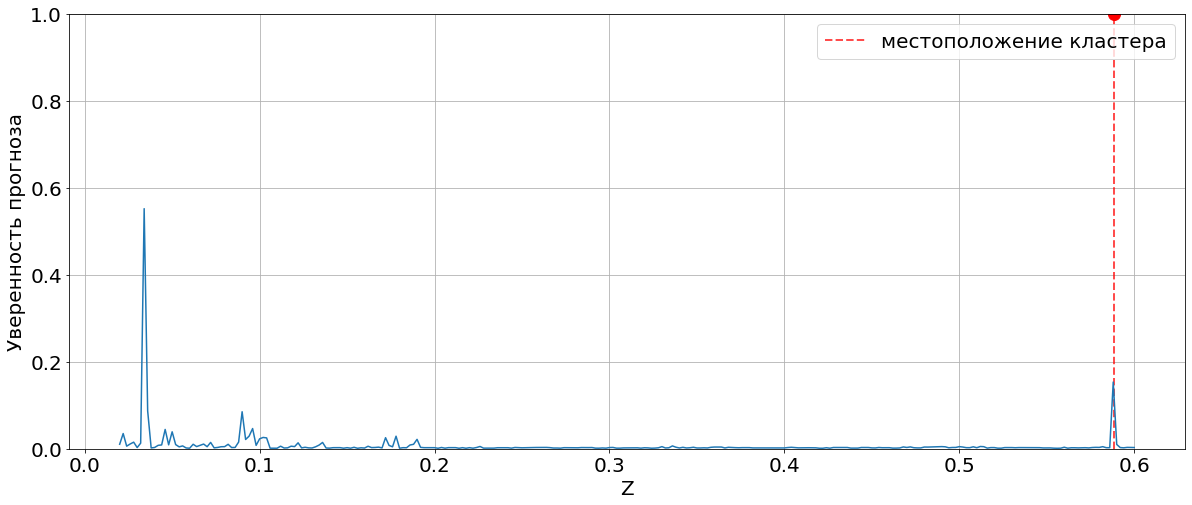

In [118]:
font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(20, 8))
plt.grid()
plt.ylim(0, 1)

ID = 3510

plt.plot(
    clusters_ext_f[clusters_ext_f['ID'] == ID]['Z'],
    clusters_ext_f[clusters_ext_f['ID'] == ID]['boosting_score'],
#     label='boosting_score'
)

plt.plot(
    clusters_ext_f[clusters_ext_f['ID'] == ID]['Z_true'].iloc[0], 
    1, 'ro', markersize=12
)
plt.vlines(
    clusters_ext_f[clusters_ext_f['ID'] == ID]['Z_true'].iloc[0],
    0, 1, colors='r', linestyles='--', linewidth=2, alpha=0.7, label='местоположение кластера'
)

plt.xlabel('Z')
plt.ylabel('Уверенность прогноза')
plt.legend()

In [79]:
def quart_rocauc(score, no_gal_mask=None):
    if no_gal_mask is None:
        no_gal_mask = np.array([True] * len(score))
    
    m_quarts = [0]
    for q in (0.25, 0.5, 0.75, 1):
        m_quarts.append(np.quantile(true_clusters_f['M'].iloc[no_gal_mask[:true_clusters_f.shape[0]]], q))
    
    m_quarts_masks = []
    for i in range(1, len(m_quarts)):
        m = ((true_clusters_f['M'] > m_quarts[i-1]) & \
             (true_clusters_f['M'] <= m_quarts[i])).values
        m *= no_gal_mask[:true_clusters_f.shape[0]]
        m = np.concatenate((m, np.array([True] * false_clusters_f.shape[0])))
        
        m_quarts_masks.append(m)
        
    z_quarts = [[0], [0], [0], [0]]
    for i in range(len(m_quarts_masks)):
        for q in (0.25, 0.5, 0.75, 1):
            z_quarts[i].append(
                np.quantile(
                    clusters_f.iloc[:true_clusters_f.shape[0]].iloc[m_quarts_masks[i][:true_clusters_f.shape[0]]]['Z'], q
                )
            )
            
    z_quarts_masks = [[], [], [], []]
    for i in range(len(z_quarts_masks)):
        for j in range(1, len(z_quarts[0])):
#             m = ((true_clusters['Z'] > z_quarts[i][j-1]) & (true_clusters['Z'] <= z_quarts[i][j]) & m_quarts_masks[i][:true_clusters.shape[0]]).values
#             m = np.concatenate((m, np.array([False] * false_clusters.shape[0])))
            m = ((clusters_f['Z'] > z_quarts[i][j-1]) & (clusters_f['Z'] <= z_quarts[i][j]) & m_quarts_masks[i]).values
            m *= np.concatenate((no_gal_mask[:true_clusters_f.shape[0]], np.array([True] * false_clusters_f.shape[0])))
            z_quarts_masks[i].append(m)
          
    for i in range(len(z_quarts_masks)):
        print(f'======== {round(m_quarts[i], 2)} < M <= {round(m_quarts[i+1], 2)} ========')
        for j in range(len(z_quarts_masks[i])):
            print(f'{round(z_quarts[i][j], 2)} < Z <= {round(z_quarts[i][j+1], 2)} ---',
                round(roc_auc_score(
                    y[true_mask * z_quarts_masks[i][j] + false_mask], 
                    score[true_mask * z_quarts_masks[i][j] + false_mask]
                ), 4)
            )

In [80]:
quart_rocauc(boosting_scores_ext_lvl2)

======== 0 < M <= 1.7 ========
0 < Z <= 0.22 --- 0.6423
0.22 < Z <= 0.32 --- 0.6774
0.32 < Z <= 0.4 --- 0.7716
0.4 < Z <= 0.6 --- 0.7955
======== 1.7 < M <= 2.11 ========
0 < Z <= 0.32 --- 0.7231
0.32 < Z <= 0.42 --- 0.7351
0.42 < Z <= 0.5 --- 0.7495
0.5 < Z <= 0.6 --- 0.6924
======== 2.11 < M <= 2.6 ========
0 < Z <= 0.32 --- 0.6685
0.32 < Z <= 0.42 --- 0.6984
0.42 < Z <= 0.51 --- 0.7819
0.51 < Z <= 0.6 --- 0.8243
======== 2.6 < M <= 11.0 ========
0 < Z <= 0.31 --- 0.7757
0.31 < Z <= 0.42 --- 0.7046
0.42 < Z <= 0.51 --- 0.821
0.51 < Z <= 0.6 --- 0.8214


In [83]:
prec, recall, thrs = precision_recall_curve(y, boosting_scores_ext_lvl2)

Text(0, 0.5, 'precision')

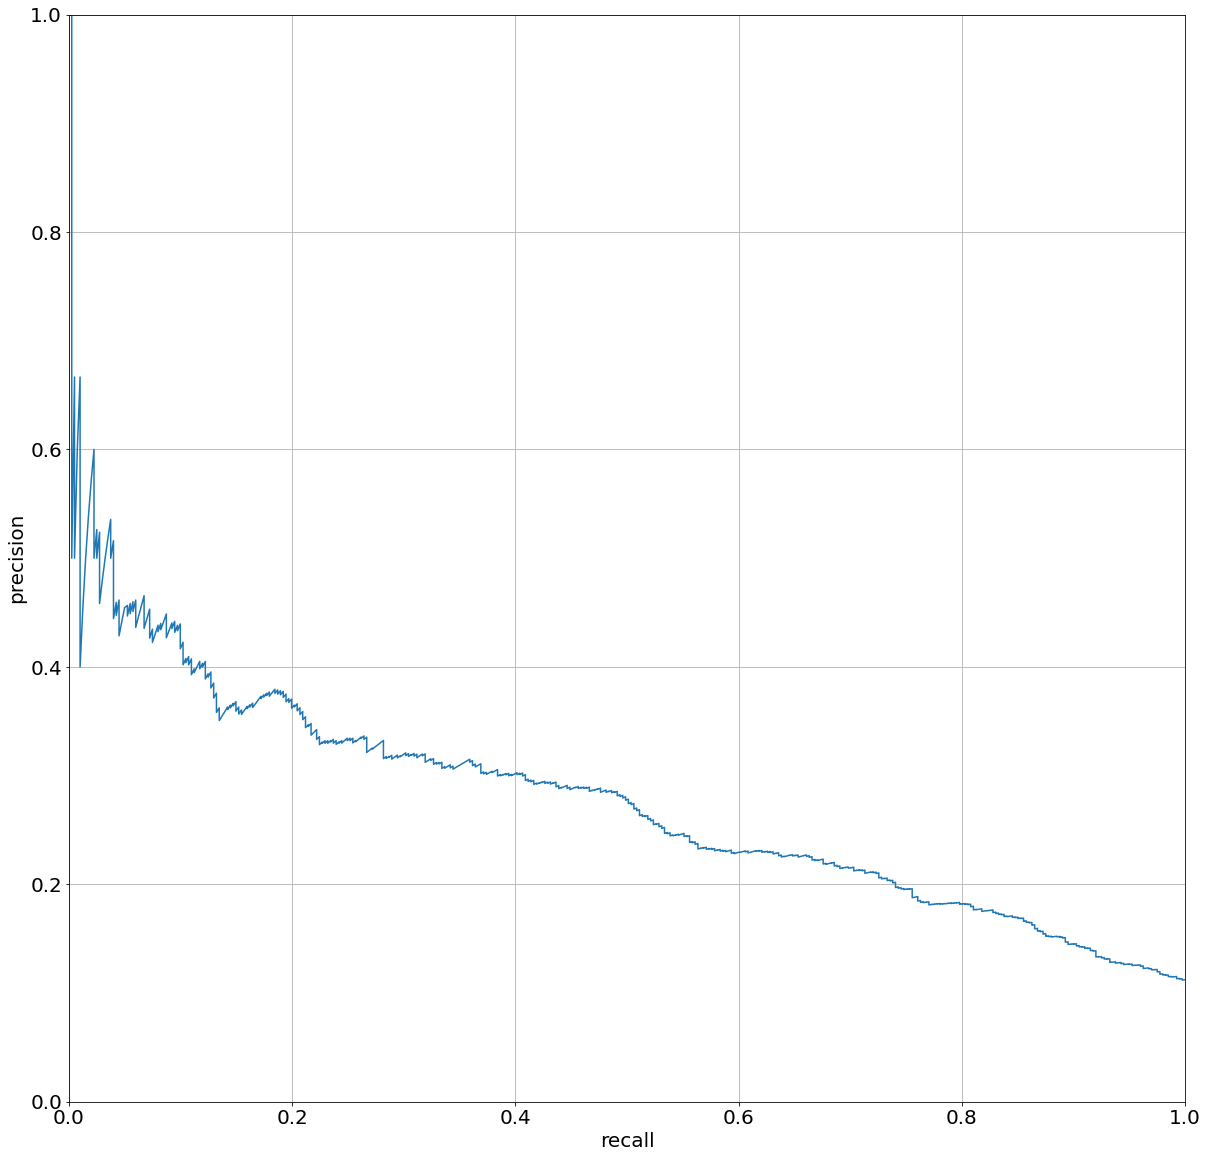

In [90]:
font = {'size': 20}
plt.rc('font', **font)
fig = plt.figure(figsize=(20, 20))
plt.grid()
plt.xlim(0, 1)
plt.ylim(0, 1)

plt.plot(recall, prec)
plt.xlabel('recall')
plt.ylabel('precision')